## Importing the Data

In [5]:
import pandas as pd
df = pd.read_csv("KaggleV2-May-2016.csv")


## Descriptive Summary

In [6]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


## Number of Rows and Columns

In [7]:
df.shape

(110527, 14)

The original dataset has 110,527 records and 14 features (input variables)

## Column Names

In [8]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

## Target Variable


In [9]:
no_show = df["No-show"].value_counts()
print(no_show)

Percent_no_show = no_show["Yes"]/ no_show.sum() * 100
print("Percent who didn't show up to their appointment:",Percent_no_show )

No     88208
Yes    22319
Name: No-show, dtype: int64
Percent who didn't show up to their appointment: 20.1932559465


## Recode Target Variable
0 =  Did not show up to appointment

1 =  Showed up to appointment

In [10]:
df['No-show'].replace("No", 0,inplace=True)
df['No-show'].replace("Yes", 1,inplace=True)


## Exploratory Analysis on Features
Count of Male vs Female

In [11]:
df["Gender"].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

## Seeing how each feature relates to the target variable.


In [12]:
Exploratory_Analysis = ['Gender','Hipertension','Alcoholism','Diabetes']
for r in Exploratory_Analysis :
    print(df.groupby(r)['No-show'].mean())
#df.groupby('Hipertension')['No-show'].mean()

Gender
F    0.203146
M    0.199679
Name: No-show, dtype: float64
Hipertension
0    0.209037
1    0.173020
Name: No-show, dtype: float64
Alcoholism
0    0.201946
1    0.201488
Name: No-show, dtype: float64
Diabetes
0    0.203628
1    0.180033
Name: No-show, dtype: float64


As shown above, gender does not seem to affect whether a person shows up to an appointment or not, as both males and females don't show up to approximately 20 percent of their appointments. Diabetes and Alcoholism don't seem to affect no-shows as well.

Hypertension seems to have a small affect, as a patient who has hypertension is 3% more likely to show up than a patient who doesn't have hyper tension.

## Handicap

The feature "handicap" has 4 categories (explanation was not provided on what each category stands for), therefore I will convert it to a categorical variable and create dummy variables to prepare it for modeling.

In [13]:
#Convert to Categorical
df['Handcap'] = pd.Categorical(df['Handcap'])
#Convert to Dummy Variables
Handicap = pd.get_dummies(df['Handcap'], prefix = 'Handicap')
df = pd.concat([df, Handicap], axis=1)


In [14]:
## See how each type of handicap affects whether a patient will show up to an appointment 
handicaps = ["Handicap_1", "Handicap_2", "Handicap_3", "Handicap_4"]
for h in handicaps:
    print(df.groupby(h)['No-show'].mean())
    

Handicap_1
0    0.202360
1    0.179236
Name: No-show, dtype: float64
Handicap_2
0    0.201932
1    0.202186
Name: No-show, dtype: float64
Handicap_3
0    0.201929
1    0.230769
Name: No-show, dtype: float64
Handicap_4
0    0.201929
1    0.333333
Name: No-show, dtype: float64


What stands out is a patient who is handicap_4 is 13 % more likely to not show up to an appointment than a person who is not handicap_4. 

## Whether the patient received a text reminder


In [15]:
df.groupby('SMS_received')['No-show'].mean()

SMS_received
0    0.167033
1    0.275745
Name: No-show, dtype: float64

Unexpecedately, patients who received a text reminder did not show up to 27% person of their appointments, where as patients who did not receive a text reminder did not show up to 17% of their appointments

## Feature Engineering

## Age


In [16]:
min_age = df.Age.min()
print("Min Age:", min_age)
max_age = df.Age.max()
print("Max Age:", max_age)


Min Age: -1
Max Age: 115


Due to the fact that minimum age is said to be -1, I will remove in the next line all records where age is < 0. I will also treat as outliers any age above a 100 due to the lack of people that live more than a 100 years.  

In [17]:
df = df[(df.Age >= 0) & (df.Age <= 100)]

## Wait Time
In my experience, if I schedule an appointment far in advance and no one reminds me, I tend to forget about it. Or by the time my appointment day arrives, I feel better and don't bother showing up. In this section, I will create a variable called "wait_time" to see if the time between the date an appointment was scheduled and the date was the appointment is,  has an affect on no-shows.

In [18]:
import numpy as np

# Converts the two variables to datetime variables
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Create a variable called "AwaitingTime" by subtracting the date the patient made the appointment and the date of the appointment.
df['AwaitingTime'] = df["AppointmentDay"].sub(df["ScheduledDay"], axis=0)

# Convert the result "AwaitingTime" to number of days between appointment day and scheduled day. 
df["AwaitingTime"] = (df["AwaitingTime"] / np.timedelta64(1, 'D')).abs()


## Number of Appointments Missed in the Past
Since PatientId is available, I created a new variable that adds how many appointments the patient has missed in the past. 

In [19]:
# Number of Appointments Missed by Patient
df['Num_App_Missed'] = df.groupby('PatientId')['No-show'].apply(lambda x: x.cumsum())


## Let's take a look what columns we have after the feature engineering

In [20]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'Handicap_0', 'Handicap_1', 'Handicap_2', 'Handicap_3', 'Handicap_4',
       'AwaitingTime', 'Num_App_Missed'],
      dtype='object')

## I will drop columns that won't be used for modeling
Drop both ID indicators as they are unique values. Drop Age, ScheduledDay, and AppointmentDay because I engineered variables that will take the place of these. I also dropped Neighbourhood because there are more than 88 neighbourhoods, and it was considerably slowing my model down. 

In [21]:
df.drop(["PatientId",'AppointmentID',
         'ScheduledDay','Handcap','AppointmentDay','Neighbourhood'], axis=1, inplace = True)

## These are the final features and  target variable

In [22]:
X = df[['Gender', 'Diabetes','Hipertension', 'Scholarship', 'SMS_received',
        'Handicap_0','Handicap_1','Handicap_2','Handicap_3','Handicap_4', 'Num_App_Missed', 'Age', 'AwaitingTime']]

y = df["No-show"]

In [23]:
#This will create dummies for the remaining variables (Gender)
X_train1 = pd.get_dummies(X)

## In the following code, I scaled the data so that all values are between 0 and 1. 
The following explanation is from MachineLearningMastery.com and explains how this scaling works:

Standardization is a useful technique to transform attributes with a Gaussian distribution and differing means and standard deviations to a standard Gaussian distribution with a mean of 0 and a standard deviation of 1.

It is most suitable for techniques that assume a Gaussian distribution in the input variables and work better with rescaled data, such as linear regression, logistic regression and linear discriminate analysis.



In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train1)
rescaledX2 = scaler.transform(X_train1)
# summarize transformed data
np.set_printoptions(precision=3)
print(rescaledX2[0:5,:])

[[-0.278  2.017 -0.33  -0.688  0.144 -0.137 -0.041 -0.011 -0.005 -0.513
   1.078 -0.615  0.734 -0.734]
 [-0.278 -0.496 -0.33  -0.688  0.144 -0.137 -0.041 -0.011 -0.005 -0.513
   0.819 -0.622 -1.363  1.363]
 [-0.278 -0.496 -0.33  -0.688  0.144 -0.137 -0.041 -0.011 -0.005 -0.513
   1.078 -0.621  0.734 -0.734]
 [-0.278 -0.496 -0.33  -0.688  0.144 -0.137 -0.041 -0.011 -0.005 -0.513
  -1.259 -0.618  0.734 -0.734]
 [ 3.594  2.017 -0.33  -0.688  0.144 -0.137 -0.041 -0.011 -0.005 -0.513
   0.819 -0.622  0.734 -0.734]]


## Logistic Regression


In [25]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

# Create Training and Test Dataset with 75% Training and 25% Test
X_train, X_test, y_train, y_test = train_test_split(rescaledX2, y, test_size=0.25)

# Run Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Analyze results
print("Results:")
print("Accuracy", metrics.accuracy_score(y_test,y_pred))

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:",metrics.precision_score(y_test, y_pred))

#Sensitivity:
print("Recall:",metrics.recall_score(y_test, y_pred))

C:\Users\Antonio\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Results:
Accuracy 0.865399927615
Specificity: 0.953621748555
False Positive Rate: 0.0463782514451
Precision: 0.731222193143
Recall: 0.509296390813


## Class Distribution
The null accuracy is 79.7 %, which means that if there is no model, and we 'naivly' predict that everyone will show up, we will be right 79.7 % of the time. That means the model needs to do better than this base accuracy in order to be useful.

In [26]:
# examine the class distribution of the testing set (using a Pandas Series method)
print("Class Distribution:", y_test.value_counts())
# calculate the percentage of ones
print("Percentage of Ones:", y_test.mean())

# calculate the percentage of zeros
print("Percentage of Zeros:", 1 - y_test.mean())

# calculate null accuracy (for binary classification problems coded as 0/1)
print("Null Accuracy:",max(y_test.mean(), 1 - y_test.mean()))

Class Distribution: 0    22144
1     5486
Name: No-show, dtype: int64
Percentage of Ones: 0.19855229822656534
Percentage of Zeros: 0.8014477017734347
Null Accuracy: 0.8014477017734347


The model is 89.88 % accuracate on the test set, which is an improvement of 10.18% better than a naive model. 

Recall: Out of the ones that did not show up, how many did we predict correctly? 75 %

Precision: Out of the ones our model said will not show up, how many didn't ? 74 %



In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(rescaledX2, y, test_size=0.25, random_state = 42)

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(X_train2, y_train2)
y_pred2 = tree.predict(X_test2)
print('Accuracy on the training subset: {:.3f}'.format(tree.score(X_train2, y_train2)))
print('Accuracy on the test subset: {:.3f}'.format(tree.score(X_test2, y_test2)))


# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test2, y_pred2)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:",metrics.precision_score(y_test2, y_pred2))

#Sensitivity:
print("Recall:",metrics.recall_score(y_test2, y_pred2))

Accuracy on the training subset: 0.926
Accuracy on the test subset: 0.918
Specificity: 0.927827111272
False Positive Rate: 0.0721728887278
Precision: 0.753938832252
Recall: 0.878193594818


The model is 92 % accuracate on the test set, which is an improvement of 12.1% better than a naive model.

Recall: Out of the ones that did not show up, how many did we predict correctly? 88 %

Precision: Out of the ones our model said will not show up, how many didn't ? 76 %

To determine which metric to use, we need to do a cost-benefit analysis. 
Implications:
True Positive: Model says patient wil not show up, and they don't
False Positive: Model says patient will not show up, but they do
True Negative: Model says patient will show up, and they do
False Negative: Model says a patient will show up, but they don't

To determine which metric to use, we need to do a cost-benefit analysis. 
If we say a patient will not show up, but they do, the office would be booked and patients will have to wait and they will get upset. If we say a patient will show up, but they don't then the doctor's office will lose money because another patient could have been served at that time. 

Based on domain knowledge and past experiences, the office would rather overbook than have empty time in their schedule. Therefore, recall is the metric they care about, and based on recall, the decision tree clasifier performed the best at 88%. 

## Most important features

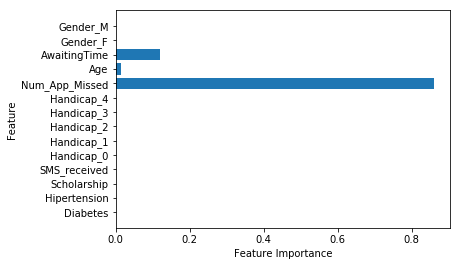

In [28]:
import matplotlib.pyplot as plt
n_features = X_train1.shape[1]
plt.barh(range(n_features), tree.feature_importances_, )
plt.yticks(np.arange(n_features), X_train1)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

Most important features are:
    - Age of the patient
    - WaitingTime (how long in advanced was appointment scheduled)
    - Number of appointments missed in the past
    


## Explore Important Features 
## Age

In [29]:
bins = [0, 20, 40, 60, 100]
age_groups = df.groupby(pd.cut(df.Age, bins))
age_groups["No-show"].mean()


Age
(0, 20]      0.228090
(20, 40]     0.229790
(40, 60]     0.185865
(60, 100]    0.152012
Name: No-show, dtype: float64

The data shows that patients over 40 are more likely to show up than patients under 40, and patients over the age of 60 are 7% more likely to shows up than patients under 40.

## Awaiting Time


In [30]:
bins = [0,1,7, 180]
wait_time = df.groupby(pd.cut(df.AwaitingTime, bins))
wait_time["No-show"].mean()

AwaitingTime
(0, 1]      0.066365
(1, 7]      0.246979
(7, 180]    0.320552
Name: No-show, dtype: float64

People who scheduled 1 day or less in advance of their appointment, did not show up only 6.6 % of the time. Those that scheduled more than 1 day but less than 1 week in advance, did not show up 25 % of the time, and those who scheduled more than 2 weeks in advance did not show up more than 30% of the time.The results did not surprise me. Based on my experience, when I schedule an appointment too far in advance, I either forget to go to it if I'm not remided, or I feel better by the time the appointment comes and don't go.